# 0. Drahtlose Kommunikation

## 0.1 Bildquellen und Vorlesungsinhalte
Die in diesem Dokument verwendeten Bilder, sofern sich nicht mit dem hier aufgeführten Code generiert wurden, stammen aus dem PC-Übungsskript "Drahtlose Kommunikation - MATLAB Rechenübung" von Dipl. -ing Lutz Molle und Prof. Dr. -ing. Markus Nölle an der HTW Berlin. Sie wurden teilsweise zur besseren Darstellung von mir verändert.


# 1. Simulation des Übertragungssystems

Die Funktionen werden immer paarweise implementiert, da sie ähnlich wie beim OSI Modell komplementäre Funktionen ausüben.
In diesem Abschnitt werden **nur die Funktionen** implementiert.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
from tqdm import tqdm
from typing import List, Set, Dict, Tuple, Any, Callable

In [2]:
%load_ext lab_black
IPython.display.set_matplotlib_formats("pdf", "svg")

## 1.1 Quelle und Senke
![Quelle und Senke](Images/01_Quell_Senke.png)

Documentation for functions that are not in the standard library for **generate_bits**:
- [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) (Object)
- [numpy.random.randint](https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.randint.html) (Function)

In [3]:
def generate_bits(n_bits: int) -> np.ndarray:
    """
    Generates a numpy array with n_bits equally distributed values between 0 and 1.

    :param n_bits: Number of bits to generate.
    :return: Randomly generated vector.
    """

    # Sanity checks:

    # Is n_bits a int?:
    if not isinstance(n_bits, int):
        raise TypeError("Expected n_bits to be of type int.")

    bit_vector: np.ndarray = np.random.randint(0, 2, size=n_bits)
    return bit_vector

Documentation for functions that are not in the standard library for **count_errors**:
- [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) (Object)
- [numpy.count_nonzero](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html) (Function)

In [4]:
def count_errors(true_values: np.ndarray, test_values: np.ndarray) -> Tuple[int, float]:
    """
    Compare two vectors. Report the number of different elements and the ratio of different elements.

    :param true_values: Actual values.
    :param test_values: Values to be compared.
    """

    # Sanity checks:

    # Do both vectors have the same length?
    if len(true_values) != len(test_values):
        raise ValueError("Lengths of bit vectores are different.")

    # Do both vectors consist only of the values 0 and 1?
    true_value: np.int64
    test_value: np.int64
    for true_value, test_value in zip(true_values, test_values):
        if true_value != 0 and true_value != 1:
            raise TypeError(f"Expected true_values to be ether 0 or 1. Got: {item}")
        if test_value != 0 and test_value != 1:
            raise TypeError(f"Expected test_values to be ether 0 or 1. Got: {item}")

    # Check for equality.
    equal_bits: np.bool_
    equal_bits = true_values == test_values

    # False bits are "non equal" bits.
    n_error: int = len(true_values) - np.count_nonzero(equal_bits)

    # BER is errors devided by number of all elements.
    bit_error_rate: float
    bit_error_rate = n_error / len(true_values)
    return (n_error, bit_error_rate)

# 1.2 Mapper, Demapper, Entscheider
![Mapper, Demapper, Entscheider](Images/03_Mapper.png)

In [5]:
def mapper(bits: np.ndarray, constellation: Dict[Tuple, complex]) -> np.ndarray:
    """
    Encode a vector of bits into a vector of compleex constellation symbols.

    :param bits: Bits to be mapped to symbols.
    :param constellation: Association of bits with constellation symbols..
    :return: Assigned symbols.
    """

    # Sanity checks:

    # Does the vector have the right length for the constellation?
    if 2 ** len(bits) % len(constellation) != 0:
        raise ValueError(f"Bit vector has not the right length.")

    symbols: List[complex]  # Assigned symbols.
    symbols = []
    slices: List[complex]  # Bit Fractions to look up in constellation.
    slices = []
    bits_per_symbol: int = int(np.log2(len(constellation)))
    for bit in bits:
        slices.append(bit)  # Add each bit so fraction list.
        # Until list carrys information for one symbol.
        if len(slices) == bits_per_symbol:
            # Add symbol to mapped symbols list.
            symbols.append(constellation[tuple(slices)])
            slices = []  # Clear fraction list.

    return np.array(symbols)

Documentation for functions that are not in the standard library for **decission**:
- [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) (Object)
- [numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) (Function)

In [6]:
def decission(symbols: np.ndarray, constellation: Dict[Tuple, complex]) -> np.ndarray:
    """
    Give a vector of symbols back corresponding to the smallest Eukliedian distance
    between the given symbols and the symbols given in the constellation.

    :param symbols: List of noisy input symbols.
    :param constallation: Table of constallation symbols.
    :return: List of decided symbols.
    """

    # Write possible constellation symbols in a vector.
    constellation_vector: np.ndarray
    constellation_vector = np.array([constellation[key] for key in constellation])

    ## Normalize symbols to constellation.
    # Get RMS of constellation.
    constellation_rms: np.ndarray
    constellation_rms = np.sqrt(np.mean(np.abs(constellation_vector) ** 2))
    # Get RMS of Symbols.
    symbols_rms: np.ndarray
    symbols_rms = np.sqrt(np.mean(np.abs(constellation_vector) ** 2))
    # Gain factor of symbols.
    normalisation_factor: np.ndarray
    normalisation_factor = symbols_rms / constellation_rms
    # Normalized symbols.
    symbols = symbols / normalisation_factor

    ## Decision for the best symbol
    decission: List[complex] = []  # List of symbols decided.
    # Calculate for every symbol...
    for symbol in symbols:
        distance: List[complex] = []  # List of distance to all constellation symbols.
        # ... distance to every constellation symbol.
        for const_symbol in constellation_vector:
            # 2-nor (Euclidean norm)
            distance.append(np.linalg.norm(const_symbol - symbol))
        # Decide for smallest distance.
        const_index = distance.index(min(distance))
        decission.append(constellation_vector[const_index])
    return np.array(decission)

Documentation for functions that are not in the standard library for **demapper**:
- [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) (Object)
- [numpy.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) (Function)
- [numpy.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html) (Function)

In [7]:
def demapper(symbols: np.ndarray, constellation: np.ndarray) -> np.ndarray:
    """
    Return a bit vector corresponding to the given symbols.

    :param symbols: Vector of symbols carrying information.
    :param constellation: Table of constallation symbols.
    :return: Byte information.
    """

    # Reverse the constellation table
    reverse_constallation: Dict(Tuple, str)
    reverse_constallation = dict([(constellation[key], key) for key in constellation])

    # For every symbol store bit equivalent.
    bit_tuples: List[Tuple[int, int]]
    bit_tuples = [reverse_constallation[symbol] for symbol in symbols]

    # Convert list to vector
    bits = np.array(bit_tuples)
    # Clear dimension
    bits = np.reshape(bits, newshape=(1, -1))
    bits = np.squeeze(bits)

    return np.array(bits)

# 1.4 Kanal (Funk, Kabel, ...)
![Kanal (Funk, Kabel, ...](Images/04_Kanal.png)

### 1.4.1 AWGN

Documentation for functions that are not in the standard library for **awgn**:
- [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) (Object)
- [numpy.sqrt](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html) (Function)
- [numpy.square](https://numpy.org/doc/stable/reference/generated/numpy.square.html) (Function)
- [numpy.absolute](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html) (Function)
- [numpy.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) (Function)
- [numpy.ndarray.view](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.view.html)(Function)
- [numpy.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html)(Function)

In [8]:
# Ideas from:
# https://stackoverflow.com/a/53688043
# 8 Dec 2018 at 23:31 by tmcdevitt
def awgn(signal: np.ndarray, snr_s: float):
    """
    Add additives white gaussian noise.

    :param signal: Singal to which noise is to be added.
    :param snr_b: Signal to noise ratio per symbol in dB.
    :return: Signal with noise.
    """
    # Calculate signal power
    signal_pwr: np.int64
    signal_pwr = np.mean(np.mean(np.square(np.abs(signal))))

    # SNR linear
    snr_linear: float = 10 ** (snr_s / 10)

    # Noise Power linear
    nois_power_linear: float = signal_pwr / snr_linear

    # Generate noise samples
    # Half of noise power to I, half of nois powert to Q component.
    mean_noise: float = 0.0
    noise = np.random.normal(
        mean_noise, np.sqrt(nois_power_linear / 2), size=(len(signal), 2)
    )
    noise = np.squeeze(noise.view(np.complex), axis=1)
    # noise = np.random.normal(mean_noise, np.sqrt(nois_power_linear), len(signal))

    # Noise up the original signal
    noisy_signal: np.ndarray = signal + noise
    return noisy_signal

### 1.4.2 Radio fading channel NLOS

Documentation for functions that are not in the standard library for **radio_fading_channel_ray**:
- [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) (Object)
- [numpy.ndarray.view](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.view.html) (Function)
- [numpy.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) (Function)
- [numpy.sqrt](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html) (Function)
- [numpy.square](https://numpy.org/doc/stable/reference/generated/numpy.square.html) (Function)
- [numpy.absolute](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html) (Function)
- [numpy.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html)(Function)
- [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) (Function)

In [9]:
def radio_fading_channel_ray(n_samples: np.ndarray) -> np.ndarray:
    """
    Generate Rayleigh distributed channel coefficients. These are Gaussian
    distributed channel coefficients each in I and Q component.

    :param n_samples: Number of channel coefficients.
    :return: Vector of complex channel coefficients.
    """
    mean_noise: float = 0.0
    std_dev: float = 1.0
    samples: np.ndarray
    # Generate normal distibutet samples.
    samples = np.random.normal(mean_noise, std_dev, size=(n_samples, 2))
    # Cast values to complex.
    samples = np.squeeze(samples.view(np.complex), axis=1)
    
    ## Normalize Channel coefficents.
    # Calculate RMS.
    samples_rms = np.sqrt(np.mean(np.square(np.abs(samples))))
    # Normalize to RMS = 1
    # Normalization of the channel components in order not to amplify.
    samples /= samples_rms  
    return samples

### 1.4.3 Radio fading channel NLOS + LOS

Documentation for functions that are not in the standard library for **radio_fading_channel_ric**:
- [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) (Object)
- [numpy.ndarray.view](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.view.html) (Function)
- [numpy.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) (Function)
- [numpy.sqrt](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html) (Function)
- [numpy.square](https://numpy.org/doc/stable/reference/generated/numpy.square.html) (Function)
- [numpy.absolute](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html) (Function)
- [numpy.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html)(Function)
- [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) (Function)

In [37]:
def radio_fading_channel_ric(n_samples: np.ndarray, k) -> np.ndarray:
    """
    Generate Rice-distributed channel coefficients.
    This simulates a Rice channel with adjustable ratio
    of NLOS and LOS component.

    n_samples: Number of channel coefficients.
    :return: Vector of complex channel coefficients.
    """

    # Expected value of the distributions
    mean_noise: float = 0.0

    ## NLOS path
    std_dev_nlos: float = 1.0
    # Generate normal distibutet samples.
    samples_nlos = np.random.normal(mean_noise, std_dev_nlos, size=(n_samples, 2))
    # Cast values to complex.
    samples_nlos = np.squeeze(samples_nlos.view(np.complex), axis=1)
    # Calculate average power.
    smples_nlos_pwr = np.mean(np.square(np.abs(samples_nlos)))  # Leistung

    ## LOS path
    # Calculate LOS power as a function of NLOS power.
    los_pwr = k * smples_nlos_pwr
    # Calculate LOS RMS
    los_rms = np.sqrt(los_pwr)
    # Calculate radnom phases (once around the circle)
    los_phases = np.random.uniform(low=-np.pi, high=np.pi, size=n_samples)
    samples_los = samples_los = 1 * np.exp((1j * los_phases))
    # Amplify LOS
    samples_los *= los_rms

    # Overlay NLOS + LOS
    rice_samples = samples_nlos + samples_los

    ## Normalize Channel coefficents.
    # Calculate RMS.
    rice_rms = np.sqrt(np.mean(np.square(np.abs(rice_samples))))  # RMS
    # Normalize to RMS = 1
    # Normalization of the channel components in order not to amplify.
    rice_samples /= rice_rms
    return rice_samples, samples_los, samples_nlos

# 2. Demonstration der einzelnen Funktionen

## 2.1 Quelle und Senke

### 2.1.1 Quelle

The source generates a random bitstream with length n bits.

In [38]:
random_bits: np.ndarray = generate_bits(10)
print(f"Random bits: {random_bits}")

Random bits: [1 0 1 1 1 0 0 1 0 1]


### 2.1.2 Senke
In the sink the incoming bits are compared with the true bits. The absuluta number of errors and the BER are calculated.In the sink the incoming bits are compared with the true bits. The absuluta number of errors and the BER are calculated. 
$BER = \frac{incorrectincorrect}{total bitstotal bits}$
The worst possible $BER = 0.5$. With a higher BER one would recover information by inverting the bits.The worst possible BER is 0.5. With a higher BER one would recover information by inverting the bits.

In [39]:
true_values: np.ndarray = np.array([1, 1, 1, 0])
test_values: np.ndarray = np.array([1, 0, 1, 0])
errors: int
ber: float
errors, ber = count_errors(true_values, test_values)

print(f"Sent bits:      {true_values}")
print(f"Received bits:  {test_values}")
print(f"Incorrect bits: {bit_errors}")
print(f"BER:            {ber}")

Sent bits:      [1 1 1 0]
Received bits:  [1 0 1 0]
Incorrect bits: 0
BER:            0.25


## 2.2 Mapper, Demapper, Entscheider

Mapper symbols from [LTE Specification](https://www.etsi.org/deliver/etsi_ts/136200_136299/136211/13.07.01_60/ts_136211v130701p.pdf) S. 133f

In [92]:
def constellation_mappings() -> Dict[str, Dict[str, Dict[Tuple, complex]]]:
    """
    Provide constellations.

    :return: Constellations
    """
    bpsk: Dict[Tuple, complex]
    bpsk = {
        (0,): +1 + 1j,
        (1,): -1 - 1j,
    }

    bpsk_lte: Dict[Tuple, complex]
    bpsk_lte = {
        (0,): +1 / np.sqrt(2) + 1j * (1 / np.sqrt(2)),
        (1,): -1 / np.sqrt(2) - 1j * (1 / np.sqrt(2)),
    }

    qpsk: Dict[Tuple, complex]
    qpsk = {
        (0, 0): +1 + 1j,
        (0, 1): +1 - 1j,
        (1, 0): -1 + 1j,
        (1, 1): -1 - 1j,
    }

    qpsk_lte: Dict[Tuple, complex]
    qpsk_lte = {
        (0, 0): +1 / np.sqrt(2) + 1j * (1 / np.sqrt(2)),
        (0, 1): +1 / np.sqrt(2) - 1j * (1 / np.sqrt(2)),
        (1, 0): -1 / np.sqrt(2) + 1j * (1 / np.sqrt(2)),
        (1, 1): -1 / np.sqrt(2) - 1j * (1 / np.sqrt(2)),
    }

    c16Qam_lte: Dict[Tuple, complex]
    c16Qam_lte = {
        (0, 0, 0, 0): +1 / np.sqrt(10) + 1j * (1 / np.sqrt(10)),
        (0, 0, 0, 1): +1 / np.sqrt(10) + 1j * (3 / np.sqrt(10)),
        (0, 0, 1, 0): +3 / np.sqrt(10) + 1j * (1 / np.sqrt(10)),
        (0, 0, 1, 1): +3 / np.sqrt(10) + 1j * (3 / np.sqrt(10)),
        (0, 1, 0, 0): +1 / np.sqrt(10) - 1j * (1 / np.sqrt(10)),
        (0, 1, 0, 1): +1 / np.sqrt(10) - 1j * (3 / np.sqrt(10)),
        (0, 1, 1, 0): +3 / np.sqrt(10) - 1j * (1 / np.sqrt(10)),
        (0, 1, 1, 1): +3 / np.sqrt(10) - 1j * (3 / np.sqrt(10)),
        (1, 0, 0, 0): -1 / np.sqrt(10) + 1j * (1 / np.sqrt(10)),
        (1, 0, 0, 1): -1 / np.sqrt(10) + 1j * (3 / np.sqrt(10)),
        (1, 0, 1, 0): -3 / np.sqrt(10) + 1j * (1 / np.sqrt(10)),
        (1, 0, 1, 1): -3 / np.sqrt(10) + 1j * (3 / np.sqrt(10)),
        (1, 1, 0, 0): -1 / np.sqrt(10) - 1j * (1 / np.sqrt(10)),
        (1, 1, 0, 1): -1 / np.sqrt(10) - 1j * (3 / np.sqrt(10)),
        (1, 1, 1, 0): -3 / np.sqrt(10) - 1j * (1 / np.sqrt(10)),
        (1, 1, 1, 1): -3 / np.sqrt(10) - 1j * (3 / np.sqrt(10)),
    }

    constellations: Dict[str, Dict]
    constellations = {
        "bpsk": bpsk,
        "bpsk_lte": bpsk_lte,
        "qpsk": qpsk,
        "qpsk_lte": qpsk_lte,
        "16qam_lte": c16Qam_lte,
    }
    return constellations


CONSTELLATION = constellation_mappings()

### 2.2.1 Mapper

The mapper assigns a constellation symbol to a block of bits. Depending on the number, a symbol can carry several bits of information.
$symbol_{nr} \hat{=} 2^{bit_{nr}}$
Umgekehrt ${bit_{nr}} \hat{=} \log_{2}{symbol_{nr}}$

In [93]:
# Mokup bits
bits: np.ndarray = np.array([1, 0])
# Decision of the constellation
constellation = CONSTELLATION["bpsk"]
# Map bits to symbols
mapped_symbols: np.ndarray = mapper(bits, constellation)

print(f"Konstellations Tabelle:")
# Show constellation table
for key in constellation:
    print(f"{key} = {constellation[key]}")
print(f"Bits:   {bits}")
print(f"Mapped: {mapped_symbols}")

Konstellations Tabelle:
(0,) = (1+1j)
(1,) = (-1-1j)
Bits:   [1 0]
Mapped: [-1.-1.j  1.+1.j]


Representation of the installation symbolsRepresentation of the installation symbols

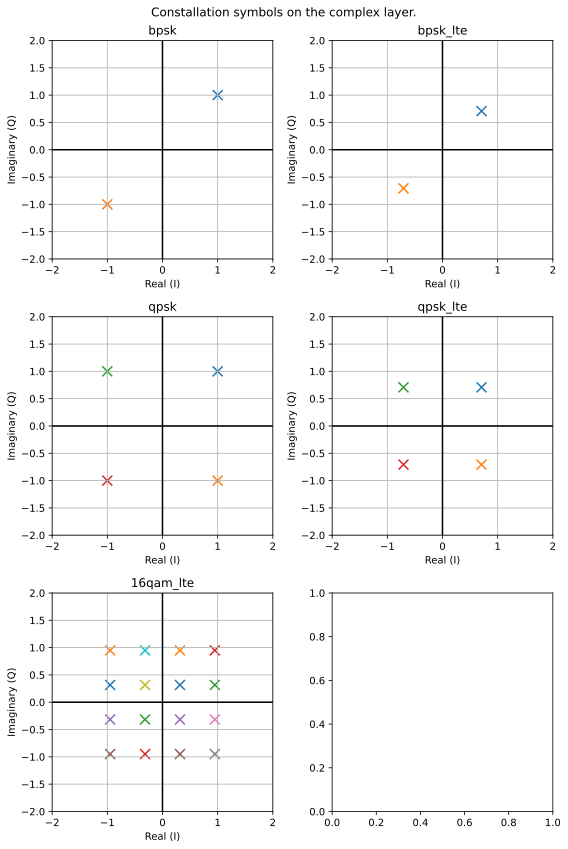

In [124]:
bits: np.ndarray = np.array([0, 1, 1, 0])
constellation: Dict[Tuple, complex] = CONSTELLATION["qpsk"]
mapped_symbols: np.ndarray = mapper(bits, constellation)

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=[8, 12])
fig.suptitle(f"Constallation symbols on the complex layer.")

for ax, const in zip(axes.flat, CONSTELLATION):
    ax.set_title(f"{const}")
    ax.set_xlabel("Real (I)")
    ax.set_ylabel("Imaginary (Q)")
    ax.grid(True)
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-2.0, 2.0)
    for symbol in CONSTELLATION[const]:
        ax.scatter(
            CONSTELLATION[const][symbol].real,
            CONSTELLATION[const][symbol].imag,
            s=100,
            marker="x",
        )
    ax.hlines(0, -2, 2, colors="black", linestyles="solid")
    ax.vlines(0, -2, 2, colors="black", linestyles="solid")

plt.tight_layout()
plt.show()

### 2.2.1 Entscheider
Entscheidet sich für das Symbol, welches zu dem empfangen Symbol die geringste eukliedische Distanz hat.

Noisy symbols:   [ 1.5+0.7j -1.2-1.3j -1. +0.9j]
Decided symbols: [ 1.+1.j -1.-1.j -1.+1.j]


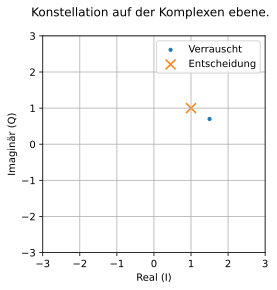

In [17]:
constellation: Dict[Tuple, complex] = CONSTELLATION["qpsk"]
noisy_symbols: np.ndarray = np.array([1.5 + 0.7j, -1.2 - 1.3j, -1 + 0.9j])
decision_symbols: np.ndarray = decission(noisy_symbols, constellation)
print(f"Noisy symbols:   {noisy_symbols}")
print(f"Decided symbols: {decision_symbols}")

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[4, 4])
fig.suptitle(f"Konstellation auf der Komplexen ebene.")

ax = fig.add_subplot(axs)
ax.grid(True)
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_xlabel("Real (I)")
ax.set_ylabel("Imaginär (Q)")

ax.scatter(
    noisy_symbols[0].real, noisy_symbols[0].imag, s=10, marker="o", label=f"Verrauscht"
)
ax.scatter(
    decision_symbols[0].real,
    decision_symbols[0].imag,
    s=100,
    marker="x",
    label=f"Entscheidung",
)

ax.legend()
plt.show()

### 2.2.2 Demapper

In [18]:
constellation: Dict[Tuple, complex] = CONSTELLATION["qpsk"]
symbols: np.ndarray = np.array([-1 + 1j, -1 - 1j, -1 + 1j])
bits: np.ndarray = demapper(symbols, constellation)
print(f"Konstellations Tabelle:")
for key in constellation:
    print(f"{key} = {constellation[key]:.2f}")
print(f"Symbols:         {symbols}")
print(f"Demapped Bits:   {bits}")

Konstellations Tabelle:
(0, 0) = 1.00+1.00j
(0, 1) = 1.00-1.00j
(1, 0) = -1.00+1.00j
(1, 1) = -1.00-1.00j
Symbols:         [-1.+1.j -1.-1.j -1.+1.j]
Demapped Bits:   [1 0 1 1 1 0]


## 2.3 AWGN

Add wihte gaussian nois to a signal.

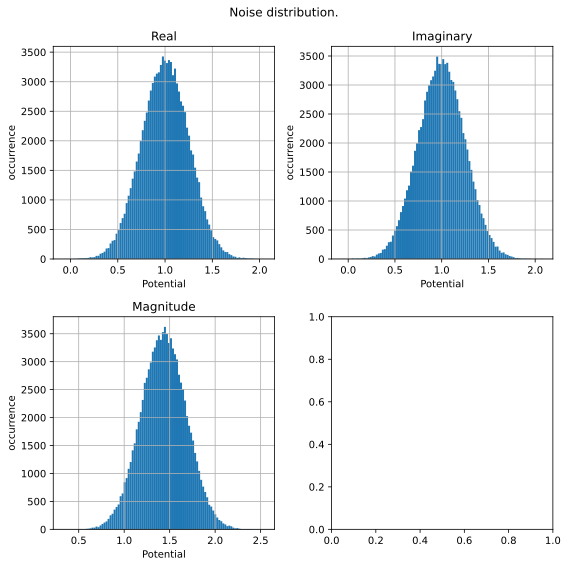

In [143]:
samples = np.squeeze(np.ones((100000, 2)).view(np.complex), axis=1)
noisy_samples: np.ndarray = awgn(samples, noise_db)
abs_symples: np.ndarray = np.abs(noisy_samples)


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[8, 8])
fig.suptitle(f"Noise distribution.")

ax0 = fig.add_subplot(axs[0, 0])
ax0.grid(True)
ax0.hist(noisy_samples.real, bins=100)
ax0.set_title("Real")
ax0.set_xlabel("Potential")
ax0.set_ylabel("occurrence")

ax1 = fig.add_subplot(axs[0, 1])
ax1.grid(True)
ax1.hist(noisy_samples.imag, bins=100)
ax1.set_title("Imaginary")
ax1.set_xlabel("Potential")
ax1.set_ylabel("occurrence")

ax2 = fig.add_subplot(axs[1, 0])
ax2.grid(True)
ax2.hist(abs_symples, bins=100)
ax2.set_title("Magnitude")
ax2.set_xlabel("Potential")
ax2.set_ylabel("occurrence")

plt.tight_layout()
plt.show()

## 2.4 Radio Fading Channel / Schwundkanal

<function matplotlib.pyplot.show(close=None, block=None)>

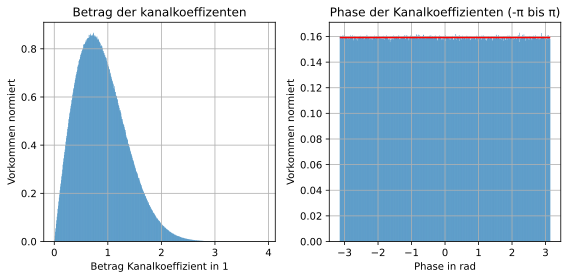

In [144]:
signal: np.ndarray = radio_fading_channel_ray(int(10e6))

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=[8, 4])
ax0 = fig.add_subplot(axs[0])
ax1 = fig.add_subplot(axs[1])

ax0.hist(np.abs(signal), bins=500, density=1)
ax0.set_xlabel("Betrag Kanalkoeffizient in 1")
ax0.set_ylabel("Vorkommen normiert")
ax0.set_title(f"Betrag der kanalkoeffizenten")
ax0.grid(True, which="major")
ax0.grid(True, which="minor")

ax1.hist(np.angle(signal, deg=False), bins=500, density=1)
ax1.hlines(
    1 / (2 * np.pi),
    -np.pi,
    np.pi,
    colors="r",
    linestyles="solid",
)
ax1.set_xlabel("Phase in rad")
ax1.set_ylabel("Vorkommen normiert")
ax1.set_title(f"Phase der Kanalkoeffizienten (-π bis π)")
ax1.grid(True, which="major")
ax1.grid(True, which="minor")

plt.tight_layout()
plt.show

# 3. Komplette Simulation

## 3.1 AWGN Kanal

### 3.1.1 Simulation

In [21]:
def simulation_awgn(n_bits, constellation, snr_b) -> Tuple[int, float]:
    """

    This is the complet simmulation of a AWGN channel.
    """
    # Generate bits
    source_bits: np.ndarray = generate_bits(n_bits)

    # Mapp symbols
    mapped_symbols: np.ndarray = mapper(source_bits, constellation)

    # Add Noise
    snr_s = snr_b * np.log2(len(constellation))
    noisy_signal: np.ndarray = awgn(mapped_symbols, snr_s)

    # Decide symbols
    decided_symbols = decission(noisy_signal, constellation)

    # Demap bits
    demapped_bits: np.ndarray = demapper(decided_symbols, constellation)

    # Count errors
    bit_errors: int
    ber: float
    bit_errors, ber = count_errors(source_bits, demapped_bits)
    return bit_errors, ber, mapped_symbols, noisy_signal

### 3.1.2 Visualisierung

#### AWGN mit QPSK

In [22]:
constellation = CONSTELLATION["qpsk"]
snr_b = 5
n_bits = 10000
bit_errors, ber, mapped_symbols, noisy_signal = simulation_awgn(
    n_bits=n_bits, constellation=constellation, snr_b=snr_b
)
print(f"Errors: {bit_errors}")
print(f"BER:    {ber}")

Errors: 7
BER:    0.0007


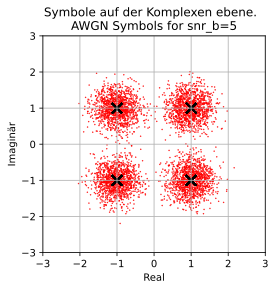

In [23]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[4, 4])
fig.suptitle(f"Symbole auf der Komplexen ebene.")

ax = fig.add_subplot(axs)

ax.grid(True)
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_xlabel("Real")
ax.set_ylabel("Imaginär")
ax.set_title(f"AWGN Symbols for snr_b={snr_b}")
ax.scatter(
    noisy_signal.real,
    noisy_signal.imag,
    s=1,
    color="r",
    alpha=1,
    marker=".",
    label="AWGN",
)
ax.scatter(
    mapped_symbols.real,
    mapped_symbols.imag,
    s=100,
    color="black",
    alpha=1,
    marker="x",
    label="Constellation",
)
plt.show()

#### AWGN mit BPSK über verschiedene SNR

In [24]:
n_min_error = 100
n_bits = 100000
max_iterations = 20
# Signal to noise rations
snr_bs: np.ndarray = np.arange(0, 12, 1)

# Error rates for each SNR
bers = []
for snr_b in snr_bs:
    loop_errors = 0
    for i in tqdm(range(max_iterations), desc=f"snr_b: {snr_b}"):
        bit_errors, ber, _, _ = simulation_awgn(n_bits, CONSTELLATION["bpsk"], snr_b)
        loop_errors += bit_errors
        if loop_errors >= 100:
            break
    bers.append(ber)

bers_a = np.array(bers)

snr_b: 11: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


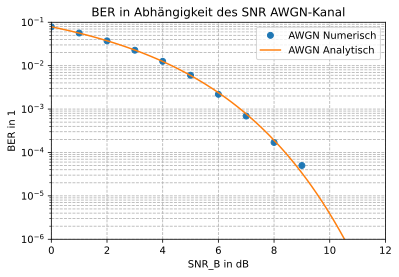

In [25]:
import math
from scipy import special

snr_awgn_anal_db = np.arange(0, 12, 0.1)
snr_awgn_anal_lin = 10 ** (snr_awgn_anal_db / 10)
ber_awgn_anal = 0.5 * special.erfc(np.sqrt(snr_awgn_anal_lin))
plt.plot(snr_bs, bers_a, "o", label="AWGN Numerisch")
plt.plot(snr_awgn_anal_db, ber_awgn_anal, label="AWGN Analytisch")
plt.legend()
plt.yscale("log")
plt.xlim(0, 12)
plt.ylim(1e-6, 1e-1)
plt.xlabel("SNR_B in dB")
plt.ylabel("BER in 1")
plt.title(f"BER in Abhängigkeit des SNR AWGN-Kanal")
plt.grid(True, which="both", linestyle="--")
plt.show()

## 3.2 Simulation des Rayleigh Kanal

### 3.2.1 Simulation Funktion

In [26]:
def simulation_rayleigh(n_bits, constellation, snr_b) -> Tuple[int, float]:
    """

    This is the complet simmulation of a Rayleigh channel.
    """
    # Generate bits
    source_bits: np.ndarray = generate_bits(n_bits)

    # Mapp symbols
    mapped_symbols: np.ndarray = mapper(source_bits, constellation)

    # Add Channel Coefficents
    channel_coefficents = radio_fading_channel_ray(len(mapped_symbols))
    fading_signal = mapped_symbols * channel_coefficents

    # Add Noise
    snr_s = snr_b * np.log2(len(constellation))
    noisy_signal: np.ndarray = awgn(fading_signal, snr_s)

    # Remove Channel Coefficents
    estimated_signal = noisy_signal / channel_coefficents

    # Decide symbols
    decided_symbols = decission(estimated_signal, constellation)

    # Demap bits
    demapped_bits: np.ndarray = demapper(decided_symbols, constellation)

    # Count errors
    bit_errors: int
    ber: float
    bit_errors, ber = count_errors(source_bits, demapped_bits)
    return (
        bit_errors,
        ber,
        mapped_symbols,
        noisy_signal,
        channel_coefficents,
        estimated_signal,
    )

In [27]:
err, ber, ms, ns, cc, es = simulation_rayleigh(10000, CONSTELLATION["qpsk"], 7)

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[9, 9])
fig.suptitle(f"Symbole auf der Komplexen ebene.")

ax0_0 = fig.add_subplot(axs[0, 0])

ax0_0.grid(True)
ax0_0.set_xlim(-3.0, 3.0)
ax0_0.set_ylim(-3.0, 3.0)
ax0_0.set_xlabel("Real")
ax0_0.set_ylabel("Imaginär")
ax0_0.set_title("Kanal koeffizienten")
ax0_0.scatter(cc.real, cc.imag, s=1, color="r", alpha=1, marker=".")

ax0_1 = fig.add_subplot(axs[0, 1])
ax0_1.grid(True)
ax0_1.set_xlim(-3.0, 3.0)
ax0_1.set_ylim(-3.0, 3.0)
ax0_1.set_xlabel("Real")
ax0_1.set_ylabel("Imaginär")
ax0_1.set_title("Mapped Symbols")
ax0_1.scatter(ms.real, ms.imag, s=100, color="r", alpha=1, marker="x")

ax1_0 = fig.add_subplot(axs[1, 0])
ax1_0.grid(True)
ax1_0.set_xlim(-3.0, 3.0)
ax1_0.set_ylim(-3.0, 3.0)
ax1_0.set_xlabel("Real")
ax1_0.set_ylabel("Imaginär")
ax1_0.set_title("Fading Symbols")
ax1_0.scatter(ns.real, ns.imag, s=1, color="r", alpha=1.0, marker="o")

ax1_1 = fig.add_subplot(axs[1, 1])
ax1_1.grid(True)
ax1_1.set_xlim(-3.0, 3.0)
ax1_1.set_ylim(-3.0, 3.0)
ax1_1.set_xlabel("Real")
ax1_1.set_ylabel("Imaginär")
ax1_1.set_title("Estimated Symbols")
ax1_1.scatter(es.real, es.imag, s=1, color="r", alpha=1.0, marker="o")
plt.tight_layout()
plt.show()

### 3.2.2 Visualisierung / Diagramme

In [29]:
n_min_error = 100
n_bits = 100000
max_iterations = 10
# Signal to noise ratios
snr_bs: np.ndarray = np.arange(0, 31, 1)

# Error rates for each SNR
bers = []
for snr_b in snr_bs:
    loop_errors = 0
    for i in tqdm(range(max_iterations), desc=f"snr_b: {snr_b}"):
        bit_errors, ber, _, _, _, _ = simulation_rayleigh(
            n_bits, CONSTELLATION["bpsk"], snr_b
        )
        loop_errors += bit_errors
        if loop_errors >= 100:
            break
    bers.append(ber)

bers_a = np.array(bers)

snr_b: 30:  30%|███       | 3/10 [00:04<00:11,  1.63s/it]


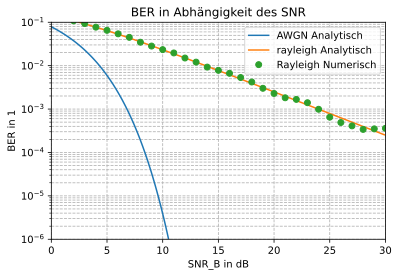

In [30]:
snr_awgn_anal_db = np.arange(0, 12, 0.1)
snr_awgn_anal_lin = 10 ** (snr_awgn_anal_db / 10)
ber_awgn_anal = 0.5 * special.erfc(np.sqrt(snr_awgn_anal_lin))
plt.plot(snr_awgn_anal_db, ber_awgn_anal, label="AWGN Analytisch")
snr_rayleigh_anal_db = np.arange(0, 30, 0.1)
snr_rayleigh_anal_lin = 10 ** (snr_rayleigh_anal_db / 10)
ber_rayleigh_anal = 0.5 * (
    1 - np.sqrt(snr_rayleigh_anal_lin / (1 + snr_rayleigh_anal_lin))
)
plt.plot(snr_rayleigh_anal_db, ber_rayleigh_anal, label="rayleigh Analytisch")
snr_rice_anal_db = np.arange(0, 12, 0.1)
snr_rice_anal_lin = 10 ** (snr_awgn_anal_db / 10)
ber_rice_anal = 0.5 * special.erfc(np.sqrt(snr_rice_anal_lin))
plt.plot(snr_bs, bers_a, "o", label="Rayleigh Numerisch")

plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(1e-6, 1e-1)
plt.legend()
plt.xlabel("SNR_B in dB")
plt.ylabel("BER in 1")
plt.title(f"BER in Abhängigkeit des SNR")
plt.grid(True, which="both", linestyle="--")
plt.show()

## 3.3 Simulation des Rice Kanal

### 3.3.1 Simulation funktion

In [31]:
def simulation_rice(n_bits, constellation, snr_b, k) -> Tuple[int, float]:
    """

    This is the complet simmulation of a Rice channel.
    """
    # Generate bits
    source_bits: np.ndarray = generate_bits(n_bits)

    # Mapp symbols
    mapped_symbols: np.ndarray = mapper(source_bits, constellation)

    # Add Channel Coefficents
    channel_coefficents, los, nlos = radio_fading_channel_ric(len(mapped_symbols), k)
    fading_signal = mapped_symbols * channel_coefficents
    los2 = mapped_symbols * los
    los2 = awgn(los2, 10)
    los2 = los2 / los
    nlos = mapped_symbols * nlos

    # Add Noise
    snr_s = snr_b * np.log2(len(constellation))
    noisy_signal: np.ndarray = awgn(fading_signal, snr_s)

    # Remove Channel Coefficents
    estimated_signal = noisy_signal / channel_coefficents

    # Decide symbols
    decided_symbols = decission(estimated_signal, constellation)

    # Demap bits
    demapped_bits: np.ndarray = demapper(decided_symbols, constellation)

    # Count errors
    bit_errors: int
    ber: float
    bit_errors, ber = count_errors(source_bits, demapped_bits)
    return (
        bit_errors,
        ber,
        mapped_symbols,
        noisy_signal,
        channel_coefficents,
        estimated_signal,
        los2,
        nlos,
    )

### 3.3.2 Visualisierung / Diagramme

In [32]:
err, ber, ms, ns, cc, es, los, nlos = simulation_rice(
    10000, CONSTELLATION["qpsk"], 10, 10000000
)

In [33]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[9, 9])
fig.suptitle(f"Symbole auf der Komplexen ebene.")

ax0_0 = fig.add_subplot(axs[0, 0])

ax0_0.grid(True)
ax0_0.set_xlim(-3.0, 3.0)
ax0_0.set_ylim(-3.0, 3.0)
ax0_0.set_xlabel("Real")
ax0_0.set_ylabel("Imaginär")
ax0_0.set_title("Kanal koeffizienten")
ax0_0.scatter(cc.real, cc.imag, s=1, color="r", alpha=1, marker=".")

ax0_1 = fig.add_subplot(axs[0, 1])
ax0_1.grid(True)
ax0_1.set_xlim(-3.0, 3.0)
ax0_1.set_ylim(-3.0, 3.0)
ax0_1.set_xlabel("Real")
ax0_1.set_ylabel("Imaginär")
ax0_1.set_title("Mapped Symbols")
ax0_1.scatter(ms.real, ms.imag, s=100, color="r", alpha=1, marker="x")

ax1_0 = fig.add_subplot(axs[1, 0])
ax1_0.grid(True)
ax1_0.set_xlim(-3.0, 3.0)
ax1_0.set_ylim(-3.0, 3.0)
ax1_0.set_xlabel("Real")
ax1_0.set_ylabel("Imaginär")
ax1_0.set_title("Symbols LOS")
ax1_0.scatter(los.real, los.imag, s=1, color="r", alpha=1.0, marker="o")

ax1_1 = fig.add_subplot(axs[1, 1])
ax1_1.grid(True)
ax1_1.set_xlim(-3.0, 3.0)
ax1_1.set_ylim(-3.0, 3.0)
ax1_1.set_xlabel("Real")
ax1_1.set_ylabel("Imaginär")
ax1_1.set_title("Symbols NLOS")
ax1_1.scatter(nlos.real, nlos.imag, s=1, color="r", alpha=1.0, marker="o")
plt.tight_layout()
plt.show()

In [34]:
n_min_error = 100
n_bits = 100000
max_iterations = 5
# Signal to noise ratios
snr_bs: np.ndarray = np.arange(0, 31, 1)
k = 10

# Error rates for each SNR
bers = []
for snr_b in snr_bs:
    loop_errors = 0
    for i in tqdm(range(max_iterations), desc=f"snr_b: {snr_b}"):
        bit_errors, ber, _, _, _, _, _, _ = simulation_rice(
            n_bits, CONSTELLATION["bpsk"], snr_b, k
        )
        loop_errors += bit_errors
        if loop_errors >= 100:
            break
    bers.append(ber)

bers_a = np.array(bers)

snr_b: 30: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


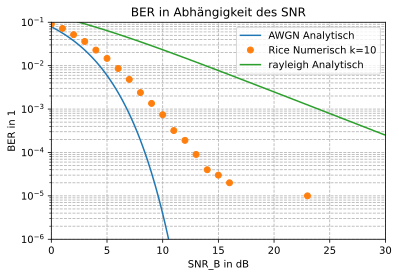

In [35]:
snr_awgn_anal_db = np.arange(0, 12, 0.1)
snr_awgn_anal_lin = 10 ** (snr_awgn_anal_db / 10)
ber_awgn_anal = 0.5 * special.erfc(np.sqrt(snr_awgn_anal_lin))
plt.plot(snr_awgn_anal_db, ber_awgn_anal, label="AWGN Analytisch")
snr_rayleigh_anal_db = np.arange(0, 30, 0.1)
snr_rayleigh_anal_lin = 10 ** (snr_rayleigh_anal_db / 10)
ber_rayleigh_anal = 0.5 * (
    1 - np.sqrt(snr_rayleigh_anal_lin / (1 + snr_rayleigh_anal_lin))
)
plt.plot(snr_bs, bers_a, "o", label=f"Rice Numerisch k={k}")
plt.plot(snr_rayleigh_anal_db, ber_rayleigh_anal, label="rayleigh Analytisch")
plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(1e-6, 1e-1)
plt.legend()
plt.xlabel("SNR_B in dB")
plt.ylabel("BER in 1")
plt.title(f"BER in Abhängigkeit des SNR")
plt.grid(True, which="both", linestyle="--")
plt.show()